# FIERpy workflow

**This notebook is a FIERpy workflow template which integrates**
1. HYDRAFloods for SAR images pre-processing
2. RESTEE for generating FIERpy input dataset
3. GEOGloWS API to get either historical or forecasted streamflow simulation
4. FIERpy for FIER process

**The workflow covers from defining Area Of Interest (AOI) to generation of inundation maps on the Date Of Interest (DOI). Cross-comparison is also possible if real SAR image is available on the DOI.**

# Install HydraFloods, RESTEE and FIERpy

Note that when installing on local PC, 
**GDAL, rasterio, fiona** may need to be installed by using source wheeler files which can be obtained from:
https://www.lfd.uci.edu/~gohlke/pythonlibs/#rasterio

Then in your virtual environment prompt , use:
pip install PATH_OF_WHEELER


In [277]:
## ----- For HydraFloods, RESTEE -----
"""
# ----- For FIERpy -----
!pip install \
     netcdf4 \
     python-qt \
     rioxarray \
     numpy \
     scipy \
     xarray==0.18.2 \
     pandas \
     scikit-learn \
     eofs \
     geoglows \
     fierpy

!pip mkl
!pip install \
    hydrafloods \
    geemap \
    numpy \
    scipy \
    pandas \
    xarray \
    rasterio \
    geopandas \
    pyproj \
    requests \
    backoff \
    earthengine-api \
    tqdm \
    restee \
    pyyaml==3.13 \
    tornado~=5.1.0
"""

# pip install -e git+http://github.com/servir/fierpy.git#egg=fierpy (For local PC, version control use)


'\n# ----- For FIERpy -----\n!pip install      netcdf4      python-qt      rioxarray      numpy      scipy      xarray==0.18.2      pandas      scikit-learn      eofs      geoglows      fierpy\n\n!pip mkl\n!pip install     hydrafloods     geemap     numpy     scipy     pandas     xarray     rasterio     geopandas     pyproj     requests     backoff     earthengine-api     tqdm     restee     pyyaml==3.13     tornado~=5.1.0\n'

In local PC, suggest that install **numpy** from source code (https://www.lfd.uci.edu/~gohlke/pythonlibs/#numpy) to install **numpy+mkl** then install **scipy, scikit-learn and fierpy**. This is to make sure **numpy, scipy, scikit-learn** can utilize **mkl**

**If facing "geos_c.dll" problem when import restee, in the prompt, run "conda install geos"**

# Import packages required

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import ee
import hydrafloods as hf
import restee
import geemap.eefolium as geemap

import xarray as xr
import rasterio as rio
import rioxarray

import numpy as np
import scipy as sci
import random
from sklearn import metrics

import pandas as pd
import datetime as dt
import fierpy
from geoglows import streamflow
#from eofs.xarray import Eof

import os
import glob
import logging
from typing import Tuple

# Define output folder

In [3]:
root_output_folder = 'D:/Research_Notebook/SERVIR/ICIMOD' #Can be changed depending on users
try:
    os.makedirs(root_output_folder)
except:
    print('root output folder exists')

root output folder exists


# Authenticate to GEE server and initiate it

In [4]:
ee.Authenticate()
ee.Initialize()

Enter verification code: 4/1AX4XfWj_ORkP791b6OaxZid2mStqo6d9dSDwiAfgLwH_A1_CCxRQeQZhPI0

Successfully saved authorization token.


# Some customized funcitons

In [55]:
def find_hydro_mode_paral(eof_stack: xr.Dataset, hydro_stack: xr.DataArray, r_type:int=0, r_thrd: float=0.5, deoutlier: int=0) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:   
    """
       Calculate correlation between temporal patterns and hydrological data.
       This helps determine water-related mode. By default,  >=0.5 is considered to be correlated.      

       # ----- Note about NSE: -----
       When NSE > 0.5, it is considered to be satisfactory (Moriasi et al., 2007). But NSE is used to evaluate model estimation
       , not the input of the model. So even when a high-NSE of model estimation can be obtained with the input, the input itself
       and the observation may not have that high NSE
       
       
       # ----- Note about Spearman's R -----
       Spearman's R may not be a robust indicator in our case. Since our data has been screened to remove those dates with 
       severe cloud cover, our data is not uniformly distributed (chances are more data will be in the dry season). 
       In this case, even the data have good linear correlation, Spearman's R can be low
       
       When Spearman's r is greater than or equal to 0.5, and the corresponding p-value is smaller than or equal to 0.05, it is considered as possibly correlated
       (Gao et al., Final Report Submitted to the St. Johns River Water Management District: STATISTICAL EVALUATION OF HYDROLOGIC DATA IN
       NORTHEASTERN FLORIDA AND SOUTHERN GEORGIA)

       args:
       1. eof_stack: Dataset with EOF or REOF results
       2. hydro_stack: DataArray with hydrological data (now GEOGloWS streamflow)
       3. r_type: 0: Pearson (default); 1: Spearman; 2: Nash-Sutcliffe
       4. r_threshold: Threshold (default: 0.6) of correlation coefficient to decide which modes are water-related
       5. deoutlier: Apply outlier removal (or not) to the hydrological data before calculating correlation
       
       output (site X modes):
       1. site_out: index for the in-situ data list
       2. mode_out: index for the eof/reof mode list
       3. r_out: corresponding r
       
    """    
    # get number of mode     
    mode_num = eof_stack.sizes['mode']    
    # get number of hydrological data sites
    site_num = hydro_stack.sizes['site']    
        
    r = np.zeros((site_num, mode_num))
    p = np.zeros((site_num, mode_num))
    
    if r_type==0:
        out_rstr='Pearson'
    elif r_type==1:
        out_rstr='Spearman'
    elif r_type==2:
        out_rstr='Nash-Sutcliffe'
      
    print('Assigned correlation type:' + out_rstr)
        
    time_tpc = eof_stack.temporal_modes.sel(mode=int(1)).time
    time_hydro = hydro_stack[0].time
    comm_indx_hydro = time_hydro.isin(time_tpc)
    comm_indx_tpc = time_tpc.isin(hydro_stack[:,comm_indx_hydro.values].time)    
    #print(hydro_stack[:,comm_indx_hydro.values].time.values)
    
    hydro_stack = hydro_stack[:,comm_indx_hydro.values].values
        
    
    
    n = len(hydro_stack)
    p_dist = sci.stats.beta(n/2 - 1, n/2 - 1, loc=-1, scale=2)    
    
    # ----- Instead of using FOR, see if it is possible to vectorize the process -----
    for ct_mode in range(mode_num):
        # get mode of tpc
        tpc = eof_stack.temporal_modes.sel(mode=int(ct_mode+1))[comm_indx_tpc]
        tpc = tpc.expand_dims(dim='site',axis=0).values
        
        r_da = np.concatenate((tpc, hydro_stack), axis=0)

        #print(r_da)
        
        if r_type == 0:
            r_mode = np.expand_dims(np.transpose(np.ma.corrcoef(np.ma.masked_invalid(r_da))[0,1:]), axis=1) 
            p_mode = 2*p_dist.cdf(-abs(r_mode))
        
        elif r_type == 1:
            r_mode_array, p_mode_array = sci.stats.spearmanr(r_da, axis=1)
            r_mode = np.expand_dims(np.transpose(r_mode_array[0,1:]), axis=1) 
            p_mode = np.expand_dims(np.transpose(p_mode_array[0,1:]), axis=1) 
        
        elif r_type == 2:
            ref_r_mode = np.expand_dims(np.transpose(np.corrcoef(r_da)[0,1:]), axis=1) 
            indx_neg = np.argwhere(ref_r_mode < 0)+1
            r_da[indx_neg,:] = -1 * r_da[indx_neg,:]
            #print(r_da[464,:])
            
            norm_r_da = sci.stats.zscore(r_da,axis=1)
            #print(norm_r_da[464,:])                        
            
            r_mode = np.expand_dims(np.transpose(1 - ( (np.sum(np.square( norm_r_da[1:,:] - norm_r_da[0,:] ), axis=1)) / (np.sum(np.square( norm_r_da[0,:] - np.mean(norm_r_da[0,:]) ))) )), axis=1)
                           
            #print(1 - ( (np.sum(np.square( norm_r_da[464,:] - norm_r_da[0,:] ))) / (np.sum(np.square( norm_r_da[0,:] - np.mean(norm_r_da[0,:]) ))) ))

        if ct_mode==0:
            r = r_mode
            if r_type==1:
                p = p_mode
        else:
            r = np.concatenate((r,r_mode), axis=1)            
            if r_type==1:
                p = np.concatenate((p,p_mode), axis=1)
      
        
          
    """
            good_tpc = match_dates(tpc, good_hydro)
            
            if len(good_hydro)==0 or len(good_tpc)==0:
                continue

        #plt.scatter(good_tpc, good_hydro)
        #plt.show()  
        
            # if streamflow is not constant all the time
            if not np.all(good_hydro==good_hydro[0]):    
                # calculate monotonic correlation between hydrological data and tpc
                # as a reference to judge their connection
                if r_type==0:
                    r[ct_site, ct_mode] = sci.stats.pearsonr(good_tpc, good_hydro)[0]
                    p[ct_site, ct_mode] = sci.stats.pearsonr(good_tpc, good_hydro)[1]
                elif r_type==1:  
                    r[ct_site, ct_mode] = sci.stats.spearmanr(good_tpc, good_hydro)[0]
                    p[ct_site, ct_mode] = sci.stats.spearmanr(good_tpc, good_hydro)[1]                
                elif r_type==2:
                    good_hydro = sci.stats.zscore(good_hydro)
                    good_tpc = sci.stats.zscore(good_tpc)
                    r[ct_site, ct_mode] = 1 - ( np.nansum(np.square(good_hydro - good_tpc))/np.nansum(np.square(good_tpc - np.nanmean(good_tpc))) )
    """
    #indx_site_mode = ((np.abs(r) >= r_thrd).astype(int)).nonzero() 
    #return r, p, indx_site_mode    
    
    #print(r)
    
    if r_type != 2:
        indx_max_r_site = np.nanargmax(np.abs(r), axis=0)
        r_temp = r[( indx_max_r_site, list(range(mode_num)) )]
        p_temp = p[( indx_max_r_site, list(range(mode_num)) )]        
        
        indx_p_sig = p_temp <= 0.05
        indx_r_sig = np.abs(r_temp) >= r_thrd
        test = (np.logical_and(np.abs(r_temp) >= r_thrd, p_temp <= 0.05))
        #print(indx_p_sig)
        #print(indx_r_sig)
        #print(test)

        mode_out = ((np.logical_and(np.abs(r_temp) >= r_thrd, p_temp <= 0.05).astype(int)).nonzero())[0]         
        
    else:        
        #print(r[463,:])
        indx_max_r_site = np.nanargmax(r, axis=0)
        #print(indx_max_r_site)
        r_temp = r[( indx_max_r_site, list(range(mode_num)) )]
        #print(r_temp)
        p_out = np.array(['NSE has no p-value'])
        mode_out = (((r_temp >= r_thrd).astype(int)).nonzero())[0]    

    site_out = indx_max_r_site[mode_out]
    r_out = r_temp[ (mode_out) ]
    if r_type != 2:
        p_out = p_temp[ (mode_out)]
    
    return site_out, mode_out, r_out, p_out
    

In [5]:
# Plotting function that will be used in FIERpy process
def ts_sc_plot(eof_stack:xr.Dataset, hydro_stack:xr.Dataset, reaches:list, indx_site:np.ndarray, indx_mode:np.ndarray, r_hydro_tpc:np.ndarray, out_folder:str, deoutlier: int=0):
    
    try:
        os.makedirs(out_folder+'/'+tpc_str)
    except:
        print('Folder exists: /'+out_folder+'/'+tpc_str)
    try:
        os.makedirs(out_folder+'/'+sm_str)
    except:
        print('Folder exists: /'+out_folder+'/'+sm_str)


    plt.set_loglevel('WARNING')              
    
    # ----- Time series plot -----
    #if len(indx_mode)==1:
    for ct_mode in range(len(indx_mode)):      
        mode = indx_mode[ct_mode]
        site = indx_site[ct_mode]
        high_r = r_hydro_tpc[ct_mode]
        tpc = eof_stack.temporal_modes.sel(mode=int(mode+1))       
        sm = eof_stack.spatial_modes.sel(mode=int(mode+1))
        hydro_single = hydro_stack[site].dropna(dim='time')
    
        if deoutlier==1:
            indx_good_hydro = (np.abs(sci.stats.zscore(hydro_single))<=3)
            hydro_site = hydro_single[indx_good_hydro]
        elif deoutlier==0:
            hydro_site = hydro_single
    
        good_hydro = fierpy.match_dates(hydro_site, tpc)
        good_tpc = fierpy.match_dates(tpc, good_hydro)
        
    
        if high_r < 0:
            good_tpc = good_tpc*-1
            sm = sm*-1
                    
        good_time = good_tpc.time
        data_len = len(good_time)    
        time_intv = int(data_len/10)
        time_list = [*range(0,data_len,time_intv)]
    
        # ----- Plot -----
        plt.plot(good_time.values, sci.stats.zscore(good_tpc), marker='+')
        plt.plot(good_time.values, sci.stats.zscore(good_hydro), marker='+')
        plt.xticks(time_list, good_time[time_list].values, rotation=45, ha='right')
        plt.xlabel('Time', fontdict=fontdict)
        plt.ylabel('Normalized value', fontdict=fontdict)
        plt.legend([tpc_str+'-'+str(mode+1).zfill(2),str(reaches[site])])
        plt.savefig(out_folder+'/'+tpc_str+'/site-'+str(reaches[site])+'_tpc'+str(mode+1).zfill(2)+'.png', dpi=300, bbox_inches='tight')
        plt.show() 
    
    
        # ----- Scatter -----
        plt.scatter(good_hydro, good_tpc)
        plt.xlabel(str(reaches[site]), fontdict=fontdict)
        plt.ylabel(tpc_str+'-'+str(mode+1).zfill(2),fontdict=fontdict)
        plt.show()  
        
        
        # ----- Spatial modes -----
        plt.figure(figsize=(plt_width, int(plt_width*(img_stackVV.sizes['lat']/img_stackVV.sizes['lon']))))
        plt.imshow(sm, cmap='jet', vmin=np.nanmin(sm)/1.5, vmax=-1*np.nanmin(sm)/1.5, interpolation='None') #, vmin=np.nanmin(sm), vmax=np.nanmax(sm))
        plt.colorbar()
        plt.title(sm_str+'-'+str(mode+1).zfill(2),fontdict=fontdict)
        plt.xticks(lon_indx_list, lon_list, rotation=45)
        plt.yticks(lat_indx_list, lat_list)        
        plt.savefig(out_folder+'/'+sm_str+'/sm-'+str(mode+1).zfill(2)+'.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # -- Output spatial modes as GeoTIFF --
        sm = sm.rename({'lon':'x', 'lat':'y'})
        sm = sm.rio.set_crs(4326)        
        sm.rio.to_raster(out_folder+'/'+sm_str+'/sm-'+str(mode+1).zfill(2)+'.tif')  

# Define Area of Interest (AOI)

**Define AOI based on World Wildlife Fund. (WWF) HydroSHEDS watershed**
1.  Users first define a pin point
2.  The AOI will be the watershed that coincides with the defined pin point

In [6]:
# ----- Define AOI watershed -----
# -- Declare pin point --
pin_lon = 91 #90.4395 #91 
pin_lat = 24.3 #23.6735 #24.3
ee_pin = ee.Geometry.Point(pin_lon, pin_lat)

# -- Define WWF HydroSHEDS level --
wwf_lv = 6
aoi = (
    ee.FeatureCollection("WWF/HydroSHEDS/v1/Basins/hybas_"+str(wwf_lv))
    .filterBounds(ee_pin)
) #.geometry()

In [7]:
# ----- Visualize AOI -----
Map = geemap.Map(center=(pin_lat, pin_lon), zoom=8)
Map.addLayer(ee_pin)
Map.addLayer(aoi, {}, 'WWF HydroSHEDS (AOI)')
Map


In [340]:
task = ee.batch.Export.table.toDrive(**
    {
        'collection': aoi,
        'folder':'FIER_AOI_KML',
        'description':'HKH',
        'fileFormat': 'KML'
    }
)
task.start()

In [341]:
task = ee.batch.Export.table.toDrive(**
    {
        'collection': aoi,
        'folder':'FIER_AOI_SHP',
        'description':'HKH',
        'fileFormat': 'SHP'
    }
)
task.start()

# Prepare the input data - Multi-temporal Sentinel-1 SAR intensity images

**Retrieve Sentinel-1 GEE ImageCollection (https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S1_GRD)**
1.  Define start year and end year
2.  Get the Sentinel-1 ImageCollection from Google Earth Engine

In [8]:
# ----- Define start and end year
start_year = '2017'
end_year = '2020'

# ----- Information of SAR images obtained from Alaska Satellite Facility (ASF) Data Vertex -----
# -- ASF Data Vertex: https://search.asf.alaska.edu 
#
# -- As we found cases that Sentinel-1 images are problematic (e.g., S1A Path 99 on 2018-03-13),
# -- the use of images are hard-coded for the smoothness of training 
#
# -- Relative orbit of Sentinel-1 images (Path) --
Rel_Orb = 150

# -- Sentinel-1 orbit direction --
Orb_Prop = 'DESCENDING'

# -- The AOI requires SAR images mosaicking (1) or not (0) --
mosaic_opt = 1

# ----- Get Sentinel-1 ImageCollection from GEE -----
S1_ImgCol = (
    ee.ImageCollection('COPERNICUS/S1_GRD')
    .filterBounds(aoi)
    .filter(ee.Filter.date(start_year+'-01-01',end_year+'-12-31'))
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
    .filter(ee.Filter.eq('relativeOrbitNumber_start',Rel_Orb))
    .filter(ee.Filter.eq('relativeOrbitNumber_stop',Rel_Orb))
    .filter(ee.Filter.eq('instrumentMode', 'IW'))
    .filter(ee.Filter.eq('platform_number', 'A'))
    .filter(ee.Filter.eq('orbitProperties_pass',Orb_Prop))
)

# ----- Exclude no-overlay acquistion -----
bad_filter=ee.Filter.date('2017-02-25','2017-03-10')
S1_ImgCol = S1_ImgCol.filter(bad_filter.Not())
bad_filter=ee.Filter.date('2018-06-20','2018-07-03') #Note that the end date is last_date+1
S1_ImgCol = S1_ImgCol.filter(bad_filter.Not())
bad_filter=ee.Filter.date('2019-05-22','2019-05-23')
S1_ImgCol = S1_ImgCol.filter(bad_filter.Not())

**Sentinel-1 ImageCollection pre-processing using HYDRAFloods (Kel et al.)**

**(https://servir-mekong.github.io/hydra-floods/)**

1.  Get the GEE Sentinel-1 ImageCollection as HYDRAFloods dataset for preprocessing
2.  Preprocessing includes 
    - Mosaicking (if necessary)
    - Slope correction (Vollrath
 et al., 2020) (DEM: https://developers.google.com/earth-engine/datasets/catalog/NASA_NASADEM_HGT_001)
    - Speckling filter (Gamma-map filter)   
3.  Clip preprocessed ImageCollection to the AOI

In [9]:
# ----- Function to clip images in the image collection -----
def img_col_clip(image):
    return image.clip(aoi)


# ----- Import GEE ImageCollection to HYDARFloods and perform preprocessing (flatten and filtering)
hf_S1_ImgCol = hf.datasets.Dataset.from_imgcollection(S1_ImgCol)
if mosaic_opt:
    hf_S1_ImgCol = hf_S1_ImgCol.aggregate_time(clip_to_area=True)
S1_ImgCol_flt_msc = hf_S1_ImgCol.apply_func(hf.slope_correction, elevation=ee.Image("NASA/NASADEM_HGT/001").select("elevation"))
S1_ImgCol_flt_msc_filt = S1_ImgCol_flt_msc.apply_func(hf.filtering.gamma_map)
S1_ImgCol_procVV = S1_ImgCol_flt_msc_filt.collection.select('VV').map(img_col_clip)
S1_ImgCol_procVH = S1_ImgCol_flt_msc_filt.collection.select('VH').map(img_col_clip)


In [10]:
# ----- Visualization parameter -----
vis_sar = {
    'min':-25,
    'max':7,
    'palette':'black,dimgray,gray,darkgray,silver,gainsboro,white'

}

reduce_aoi_S1_ImgCol = ee.ImageCollection(hf_S1_ImgCol.collection.select('VV').map(img_col_clip)).reduce(ee.Reducer.mean())
reduce_proc_hf_aoi_S1_ImgCol = ee.ImageCollection(S1_ImgCol_procVV).reduce(ee.Reducer.mean())
# ----- Visualize raw and pre-processed SAR images (mean) over the AOI for comparison -----
Map = geemap.Map(center=(pin_lat, pin_lon), zoom=8)
Map.addLayer(ee_pin)
Map.addLayer(reduce_aoi_S1_ImgCol,vis_sar,'(Raw) Mean: '+start_year+'-01-01 to '+end_year+'-12-31')
Map.addLayer(reduce_proc_hf_aoi_S1_ImgCol,vis_sar,'(Pre-processed) Mean: '+start_year+'-01-01 to '+end_year+'-12-31')
Map

**RESTEE: Request ImageCollection from GEE server and convert it to dataset that can be used in user-end Python environment**

1.  Make sure to provide the correct Google Cloud ProjectID and the credential for service account (.json)
2.  RESTEE convert GEE Image/ImageCollection to dataset that can be used in local Python environment
3.  In the SAR Images dataset, pixels over the permanent water are excluded (set as NaN) based on permenant water in the JRC Global Surface Water Mapping Data
(https://developers.google.com/earth-engine/datasets/catalog/JRC_GSW1_3_GlobalSurfaceWater)
4.  SAR images dataset will be exported to the user-defined folder which can be used for later use

In [11]:
# ----- RESTEE process -----
# Since running RESTEE can take time depending on data size, for the initial run, data will be exported as NetCDF for the use of later process --

# -- Define filename. This can be changed --
# -- Define spatial resolution (unit: degree) -- 
res = 0.005 
res_str = str(int(100000*res)).zfill(3)
img_stack_name = 'Meghna_'+start_year+"_"+end_year+"_"+res_str+"m"
# -- Try to open the dataset, if fails (dataset doesn't exist), run RESTEE -- 
if os.path.exists(root_output_folder+"/input/"+img_stack_name+"_VV.nc"):
    img_stackVV = xr.open_dataset(root_output_folder+"/input/"+img_stack_name+"_VV.nc")
else:
    
    # ----- Create a session -----
    # -- Provide Google Cloud ProjectID and the path to the credential --
    PROJECT_ID= 'fier-314819'
    CREDENTIAL='D:/Research_Notebook/credential/fier-314819-267d62ad4e0b.json'
    session=restee.EESession(PROJECT_ID, CREDENTIAL)

    # ----- Define the domain -----
    domain = restee.Domain.from_ee_geometry(session, aoi, resolution=res)    
    
    # -- GEE ImageCollection to XARRAY dataset --
    init_img_stackVV = restee.imgcollection_to_xarray(session, domain, S1_ImgCol_procVV ,bands=['VV']) 
    
    # -- sort data by time in ascending order --
    init_img_stackVV = init_img_stackVV.sortby("time")
    init_img_stackVV["time"] = init_img_stackVV["time"].dt.strftime("%Y-%m-%d")

    # ----- Make pixels out of image frame as NaN -----
    init_img_stackVV = init_img_stackVV.where(init_img_stackVV['VV']!=0)

    # ----- Only keep the pixels that consistently have data over time. Others are set as NaN -----
    img_stack_meanVV = init_img_stackVV.mean(dim='time', skipna=False, keep_attrs=True)
    indx_img_stack_nullVV = img_stack_meanVV.isnull(keep_attrs=True)
    img_stackVV = init_img_stackVV.where(~indx_img_stack_nullVV['VV'])

    # ----- Get permanent water from the JRC Global Surface Water Data from GEE (GEE Image) -----
    # ----- to mask out permanent water from the SAR dataset             
    jrc_org = (
        ee.Image("JRC/GSW1_3/GlobalSurfaceWater")
    )

    jrc_in = restee.img_to_xarray(session, domain, jrc_org, bands=['transition']) 
    jrc_aoi = jrc_in.where(~indx_img_stack_nullVV['VV'])
    pwater_mask = jrc_aoi.transition.values==1

    # ----- Mask out permanent water body -----
    img_stackVV = img_stackVV.where(~pwater_mask)

    # ----- Export dataset as NetCDF -----
    try:
        os.makedirs(root_output_folder+"/input")
    except:
        print('Folder: '+root_output_folder+'/input already exist')
    img_stackVV.to_netcdf(root_output_folder+"/input/"+img_stack_name+"_VV.nc")



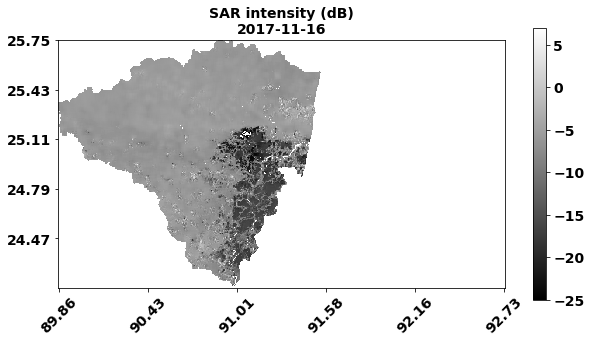

In [12]:
# ----- Visualization: Font setting -----
fontdict = {
    'weight':'bold',
    'size':14
}
matplotlib.rc('font',**fontdict)

# ----- Visualization: X/Y ticks setting -----
plt_width = 10
lon_intv = int(img_stackVV.sizes['lon']/5)
lon_indx_list = [*range(0,img_stackVV.sizes['lon'],lon_intv)]
lon_list=["{:.2f}".format(img_stackVV.lon.values[lon_indx]) for lon_indx in lon_indx_list]
lat_intv = int(img_stackVV.sizes['lat']/5)
lat_indx_list = [*range(0,img_stackVV.sizes['lat'],lat_intv)]
lat_list=["{:.2f}".format(img_stackVV.lat.values[lat_indx]) for lat_indx in lat_indx_list]

# ----- Plot example SAR intensity (Permanent water has been masked) -----
plt.figure(figsize=(plt_width, int(plt_width*(img_stackVV.sizes['lat']/img_stackVV.sizes['lon']))))
plt.imshow(img_stackVV.VV[20], cmap='gray', vmin=-25, vmax=7,interpolation='None')
plt.xticks(lon_indx_list, lon_list, rotation=45)
plt.yticks(lat_indx_list, lat_list)
plt.title('SAR intensity (dB)\n'+str(img_stackVV.time.values[20]),fontdict=fontdict)
plt.colorbar()
plt.show()

# Get hydrological data

Currently there are 2 options: (0) BWDB In-situ water level, and (1) GEOGloWS streamflow

**Get BWDB in-situ water level**

In [13]:
soi_opt = 1
#soi = np.asarray(['SW225','SW228.5','SW36','SW72','SW273']) #aoi_site
#soi = np.asarray(['SW46.9L','SW225','SW228.5','SW36','SW72','SW273']) #aoi_site_1
#soi = np.asarray(['SW91.9R','SW46.9L','SW225','SW228.5','SW36','SW72','SW273']) #aoi_site_2
#soi = np.asarray(['SW225','SW228.5','SW36','SW72']) #aoi_noSW273
soi = np.asarray(['SW36','SW72']) #aoi_site_only_sprr
#soi = np.asarray(['SW46.9L','SW225','SW228.5','SW36','SW72','SW273','SW270']) #aoi_site_6



In [14]:
hydro_opt = 0

if hydro_opt == 0:
    data_len_per=0.6
    
    #Get BWDB in-situ water level (The data is provided by Prof. Faisal Hossain, and Mr. Arifuzzaman Bhuiyan in BWDB)
    flist = glob.glob('D:/Research_Notebook/SERVIR/ICIMOD/input/insitu/Data*.xlsx')
    ct_f = 0
    for fname in flist:
        ct_f = ct_f + 1
        init_h = pd.read_excel(fname, index_col='Time', na_values='-')

        date_list = init_h.index.map(lambda t: t.date())
        uniq_date = date_list.unique()
        uniq_date.name = 'time'

        h_temp = np.empty((len(uniq_date),init_h.shape[1]))
        for ct_uniq_date in range(len(uniq_date)):
            h_temp[ct_uniq_date,:] = np.nanmean(init_h.to_numpy()[np.argwhere(date_list == uniq_date[ct_uniq_date])], axis=0)
           
        if ct_f == 1:
            hist_hydro_stack_full = xr.DataArray(
                data = h_temp,    
                dims = ['time','site'],
                coords = dict(
                    time = pd.to_datetime(uniq_date).strftime('%Y-%m-%d'),
                    #site = init_h.columns
                )
            )    
            hist_hydro_stack_full.name = 'stage'
            hist_hydro_stack_full = hist_hydro_stack_full.transpose()
            
            reaches_full = [init_h.columns[ct_site] for ct_site in range(init_h.shape[1])]            
            
        else:
            hist_hydro_stack_full2 = xr.DataArray(
                data = h_temp,    
                dims = ['time','site'],
                coords = dict(
                    time = pd.to_datetime(uniq_date).strftime('%Y-%m-%d'),
                    #site = init_h.columns
                )
            )    
            hist_hydro_stack_full2.name = 'stage'
            hist_hydro_stack_full2 = hist_hydro_stack_full2.transpose()            
            
            hist_hydro_stack_full = xr.concat( (hist_hydro_stack_full, hist_hydro_stack_full2), dim='site')
            
            reaches_full2 = [init_h.columns[ct_site] for ct_site in range(init_h.shape[1])]
            reaches_full.extend(reaches_full2)
    
    ct_data = np.asarray([np.count_nonzero(~np.isnan(hist_hydro_stack_full[ct_site,:])) for ct_site in range(hist_hydro_stack_full.shape[0])])
    indx_site_keep = ct_data>hist_hydro_stack_full.shape[1]*(data_len_per)
    hist_hydro_stack = hist_hydro_stack_full[indx_site_keep,:]
    reaches = np.asarray(reaches_full)[indx_site_keep].tolist()
    

C:\Users\Ncalm\AppData\Local\Temp/ipykernel_21084/1266295071.py:19: RuntimeWarning:

Mean of empty slice



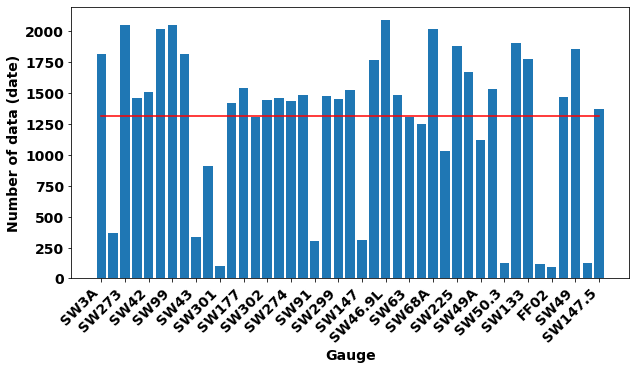

In [15]:
# Plot the number of observation
plt.figure(figsize=(10,5))
plt.plot((hist_hydro_stack_full.shape[1]*(data_len_per)*np.ones((1,len(reaches_full)))).tolist()[0], color='red')
plt.bar(list(range(0,len(reaches_full),1)), ct_data)
plt.xlabel('Gauge', fontdict=fontdict)
plt.ylabel('Number of data (date)', fontdict=fontdict)
plt.xticks(list(range(0,len(reaches_full),2)),[reaches_full[ct_site] for ct_site in list(range(0,len(reaches_full),2))], rotation=45, ha='right')
#plt.savefig(root_output_folder+'/input/insitu/data_number.png',dpi=300, bbox_inches='tight')
plt.show()

1308.6

In [16]:
if soi_opt==1:
    indx_soi=np.isin(np.asarray(reaches),soi)
    hist_hydro_stack = hist_hydro_stack[indx_soi]
    reaches = np.asarray(reaches)[indx_soi].tolist()


**Get GEOGloWS Streamflow**

Display a map for easily get the (lat, lon) of river reaches to extract GEOGloWS streamflow.
1.  In Colab, you can simply left-click on the map to get the info.
2.  In location PC, click the **info** button on the upper-right corner of the map window. A cross cursor will apear 
    for you to left-click and get the info
    
Users can enter (lat, lon) of several selected gauges per a-priori knowledge

In [18]:
if hydro_opt == 1:
    # ----- Visualization parameters -----
    vis_jrc = {
        "min":0,
        "max":100,
        "palette":"white,beige,lightblue,blue,darkblue"
    
    }    

    # ----- Get JRC water occurrence as reference for where is flood-prone -----
    jrc_water_frac = (
        ee.Image("JRC/GSW1_3/GlobalSurfaceWater")
        .select("occurrence")
    )

    Map=geemap.Map(center=(pin_lat, pin_lon),zoom=8)
    Map.addLayer(jrc_water_frac, vis_jrc, 'JRC Water Occurrence 1984 - 2020 (%)')
    Map.addLayer(reduce_proc_hf_aoi_S1_ImgCol,vis_sar,'(Pre-processed) Mean: '+start_year+'-01-01 to '+end_year+'-12-31')
    Map.addLayer(ee_pin)
    Map

Enter (lat, lon) of selected gauges per a-priori knowledge in **geoglows_lats, geoglows_lons**

In [19]:
if hydro_opt == 1:
    # lat, lon can be inspected on the above map
    geoglows_lats = [24.1965, 25.1372, 25.1432, 25.0473] 
    geoglows_lons = [90.9977, 91.1055, 91.2545, 90.5641]

    # Get historical simulation of GEOGloWS streamflows at selected gauge(s)
    hist_hydro_stack, reaches = fierpy.wrap_streamflow(geoglows_lats, geoglows_lons, forecast_opt=0)

In [552]:
"""
# Get daily mean ensembles of GEOGloWS forecasted streamflows at selected gauge(s) (historical forecast of the year)
fct_q1, reaches1 = fierpy.wrap_streamflow(geoglows_lats, geoglows_lons, forecast_opt=1)
fct_q1
"""

'\n# Get daily mean ensembles of GEOGloWS forecasted streamflows at selected gauge(s) (historical forecast of the year)\nfct_q1, reaches1 = fierpy.wrap_streamflow(geoglows_lats, geoglows_lons, forecast_opt=1)\nfct_q1\n'

In [553]:
"""
# Get daily mean ensembles of GEOGloWS forecasted streamflows at selected gauge(s) (15-day lead time)
fct_q_record1, reaches1 = fierpy.wrap_streamflow(geoglows_lats, geoglows_lons, forecast_opt=2)
fct_q_record1
"""

'\n# Get daily mean ensembles of GEOGloWS forecasted streamflows at selected gauge(s) (15-day lead time)\nfct_q_record1, reaches1 = fierpy.wrap_streamflow(geoglows_lats, geoglows_lons, forecast_opt=2)\nfct_q_record1\n'

Check organized historical hydrological data

In [18]:
hist_hydro_stack

<xarray.DataArray 'stage' (site: 2, time: 2181)>
array([[  nan,   nan,   nan, ..., 4.724, 4.694, 4.67 ],
       [  nan,   nan,   nan, ..., 5.85 , 5.636, 5.505]])
Coordinates:
  * time     (time) object '2015-04-15' '2015-04-16' ... '2021-09-26'
Dimensions without coordinates: site

In [19]:
reaches

['SW72', 'SW36']

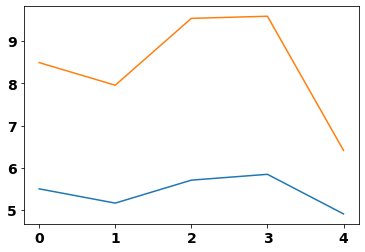

In [710]:
doi = np.asarray(['2021-07-22','2021-08-03','2021-08-15','2021-08-27','2021-09-20'])
indx_h_doi = np.isin(hist_hydro_stack.time,doi)

h_doi = hist_hydro_stack[:,indx_h_doi]

plt.plot(h_doi[0,:])
plt.plot(h_doi[1,:])
plt.show()


# EOF / REOF analysis

**Non-rotated EOF analysis (EOF)**
1.  A principal component analysis approach which can extract spatiotemporal patterns of geospatial data
2.  The extracted spatiotemporal patterns are orthogonal to each other


**Rotated EOF analysis (REOF)**
1.  Mostly, physical processes in the real world are not completely independent from each other. However, the orthogonality constraint on the unrotated spatiotemporal patterns result in the influences of several distinct physical processes being jumbled together in a single principal component. 
2.  When physical interpretation rather than data compression is a primary goal of PCA, it is often desirable to rotate a subset of the initial eigenvectors to a second set of new coordinate vectors


Perform Monte Carlo significant test


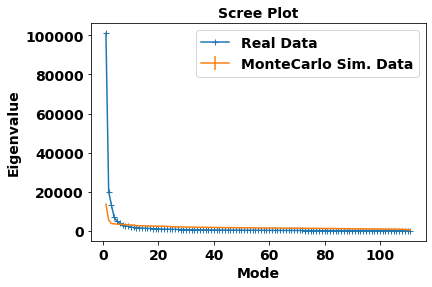

Significant mode: First 06 modes
explained variance (%):  [[[31.22640153 14.96271406 11.47084707 11.45555925  2.93836955
    2.03065638]]]


<xarray.Dataset>
Dimensions:         (lat: 320, lon: 576, mode: 6, time: 111)
Coordinates:
  * lon             (lon) float64 89.86 89.86 89.87 89.87 ... 92.72 92.73 92.73
  * lat             (lat) float64 25.75 25.75 25.74 25.74 ... 24.17 24.16 24.16
  * time            (time) object '2017-01-08' '2017-02-01' ... '2020-12-30'
  * mode            (mode) int64 1 2 3 4 5 6
Data variables:
    spatial_modes   (lat, lon, mode) float64 nan nan nan nan ... nan nan nan nan
    temporal_modes  (time, mode) float64 -185.7 1.688 -245.6 ... -79.6 -46.82
    center          (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

In [20]:
# ----- Using EOF or REOF -----
rotate_opt = 1

if rotate_opt:
    tpc_str = 'RTPC'
    sm_str = 'RSM'
    out_prefix = 'REOF'
    mdl_out_path = 'hydro2rtpc_mdl'
    wmap_out_path = '_rot'

    # ----- Significant test -----
    sig_mode = fierpy.sig_eof_test(img_stackVV.VV)
    print('Significant mode: First '+str(sig_mode).zfill(2)+' modes')
    
    # ----- Rotated EOF -----
    eof_result, var_frac = fierpy.reof(img_stackVV.VV, n_modes=sig_mode)

else:
    # ----- Unrotated EOF -----
    tpc_str = 'TPC'
    sm_str = 'SM'    
    out_prefix = 'EOF'
    mdl_out_path = 'hydro2tpc_mdl'    
    wmap_out_path = ''

    eof_result, var_frac = fierpy.unrot_eof(img_stackVV.VV, variance_threshold=0.8) # Try and see in the case of sub-basin

try:
    os.makedirs(root_output_folder+'/'+out_prefix+'/'+mdl_out_path)
except:
    print('Folder: '+root_output_folder+'/'+out_prefix+'/'+mdl_out_path+' exists')

print('explained variance (%): ',var_frac)
eof_result


In [56]:
#eof_site_list, eof_mode_list, eof_high_r_list  = fierpy.find_hydro_mode(eof_result, hist_hydro_stack, r_type=1, r_thrd=0.)
eof_site_list, eof_mode_list, eof_high_r_list, eof_low_p_list = find_hydro_mode_paral(eof_result, hist_hydro_stack, r_type=0, r_thrd=0.5)

print('reaches:',np.asarray(reaches)[eof_site_list])
print('Modes:',eof_mode_list+1)
print('Correlation:',eof_high_r_list)
print('p-value:',eof_low_p_list)

Assigned correlation type:Pearson
reaches: ['SW72' 'SW72' 'SW72' 'SW72']
Modes: [1 2 3 4]
Correlation: [ 0.76346398 -0.64129702  0.75917699  0.55836293]
p-value: [0. 0. 0. 0.]


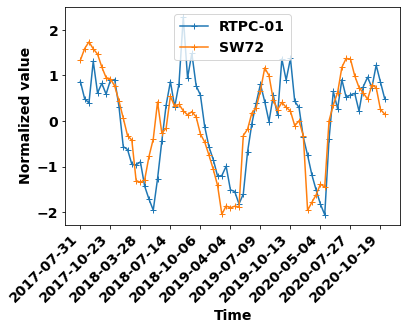

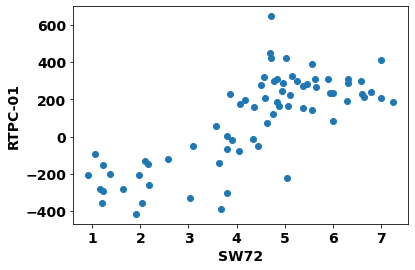

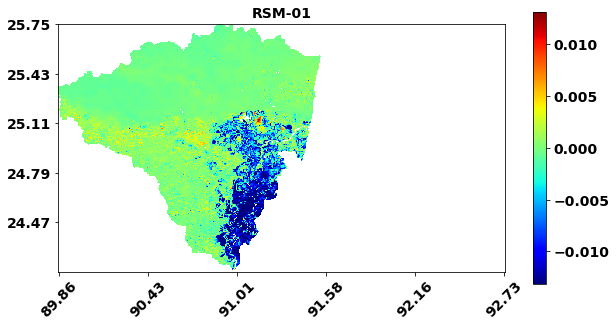

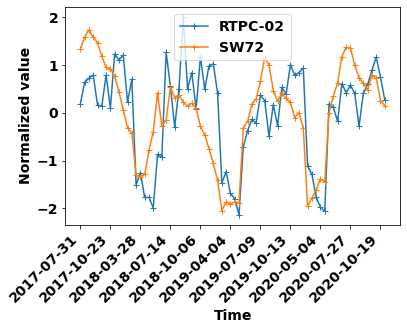

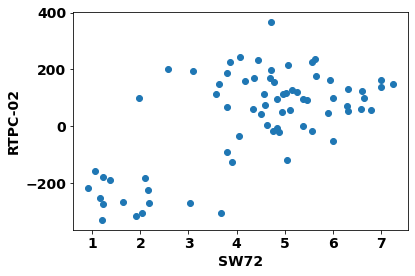

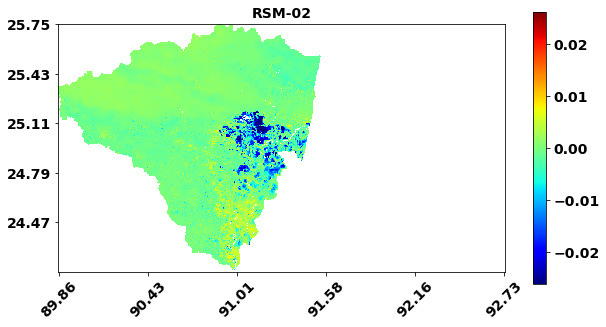

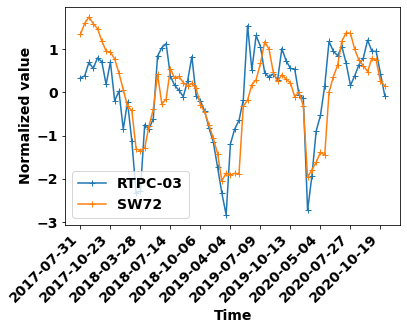

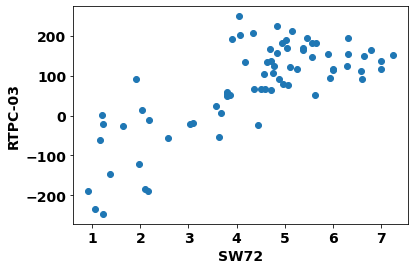

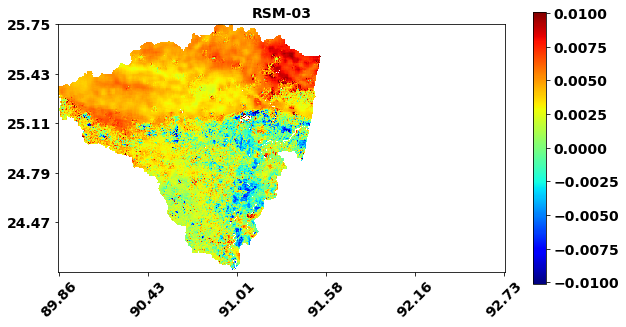

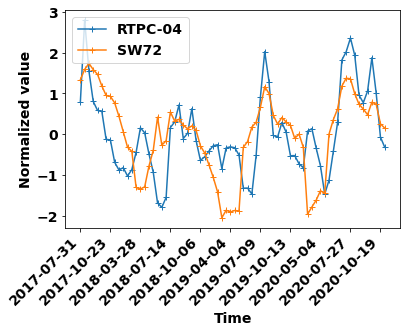

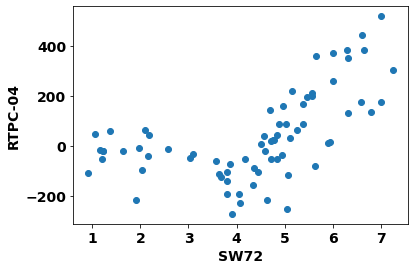

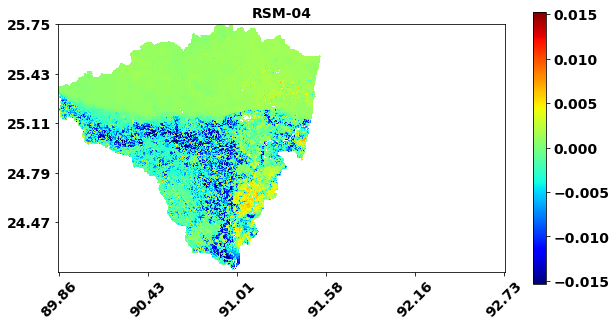

In [40]:
# ----- Plot scatter plot and time-series plot -----
out_folder=root_output_folder+'/'+out_prefix
ts_sc_plot(eof_result, hist_hydro_stack, reaches, eof_site_list, eof_mode_list, eof_high_r_list, out_folder)

# Tensorflow neural network regression

In [41]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.layers import Normalization

print(tf.__version__)

2.6.0


In [42]:
# ----- Define a callback function, setting up criteria for training to stop -----
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.000001, patience=10)


# ----- Declare Tensorflow normalizer of data -----
# -- Initialize normalization process (which axis to be along with, and the shape of input) --
# -- "input_shape=(1,)" means only one variable is used as input. 
#    Since the number of observations in a variable can be dynamic, it often remains unprovided, hence defined as (1,)
#    
#    In the case of multivariate regression, says N variables, are used as input, it becomes
#    "input_shape=(N,)"
#    
#    "axis=-1", means the mean and STD calculated in ".adapt(DATA)" is along the last dimension, which in
#    this case is along column. It depends on which axis of data represent the variable types.
normalizer = Normalization(input_shape=(1,),axis=-1) 


# ----- Design Tensorflow model structure -----
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        #layers.Dense(128, activation='relu'),
        #layers.Dense(64, activation='relu'),
        layers.Dense(1)               
    ])
    
    model.compile(loss='mean_squared_error',
                  optimizer=tf.keras.optimizers.Adam())#tf.keras.optimizers.Adam(0.001))
    return model

In [44]:
# ----- Function for plotting training progress -----
def plot_loss(history):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    plt.plot(history.history['loss'], label='loss')
    #plt.plot(history.history['val_loss'], label='val_loss')  
    plt.xlabel('Epoch',fontdict=fontdict)
    plt.ylabel('[Loss] MSE: RTPC',fontdict=fontdict)
    #plt.legend()
    plt.text(0.6,0.7,'Final loss: '+"{:.2f}".format(history.history['loss'][-1]),transform=ax.transAxes)
    plt.grid(True)
    plt.savefig(root_output_folder+'/'+out_prefix+'/'+mdl_out_path+'_TF/'+str(reaches[site])+'_tpc'+str(mode).zfill(2)+'_train_loss.png', dpi=300, bbox_inches='tight')    
    plt.show()

Folder: D:/Research_Notebook/SERVIR/ICIMOD/REOF/hydro2rtpc_mdl_TF already exists
Building models for mode-01
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 128)               256       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 33,412
Trainable params: 33,409
Non-trainable params: 3
_________________________________________________________________


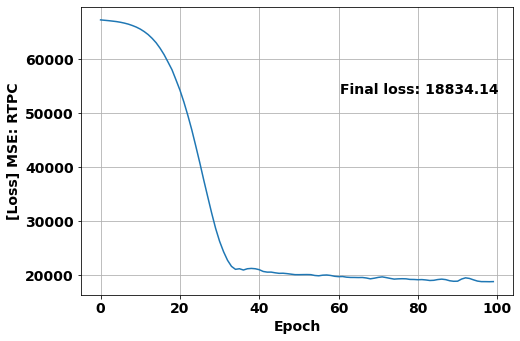

1 0.6842803658763826


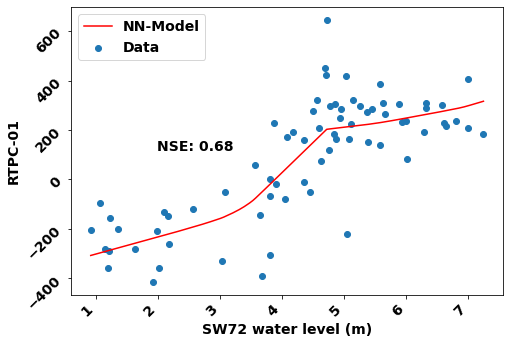

INFO:tensorflow:Assets written to: D:/Research_Notebook/SERVIR/ICIMOD/REOF/hydro2rtpc_mdl_TF/site-SW72_tpc01\assets


Building models for mode-02
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 128)               256       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 33,412
Trainable params: 33,409
Non-trainable params: 3
_________________________________________________________________


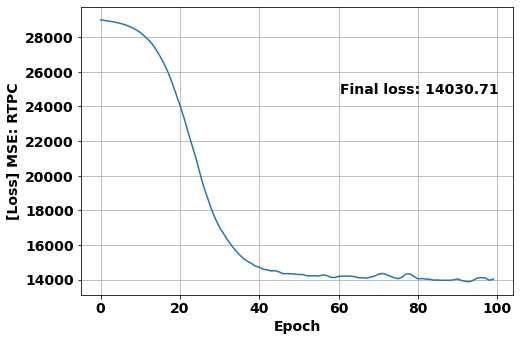

2 0.5076680963488858


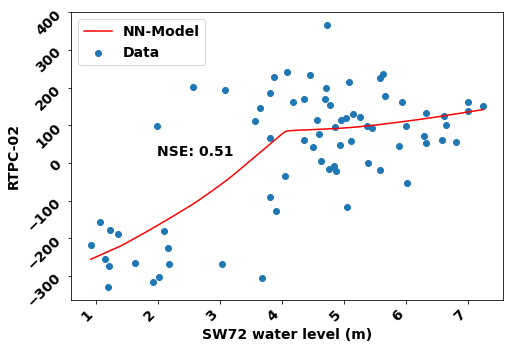

INFO:tensorflow:Assets written to: D:/Research_Notebook/SERVIR/ICIMOD/REOF/hydro2rtpc_mdl_TF/site-SW72_tpc02\assets


Building models for mode-03
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 128)               256       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 33,412
Trainable params: 33,409
Non-trainable params: 3
_________________________________________________________________


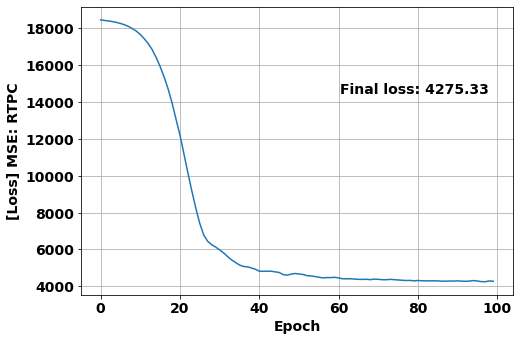

3 0.6694838669053733


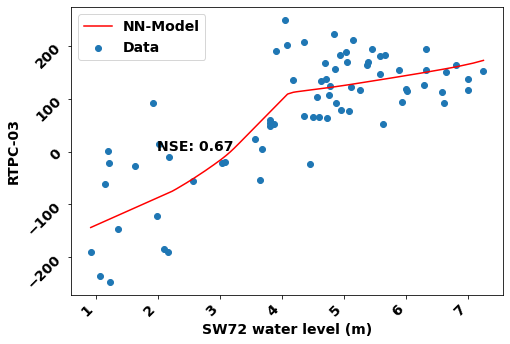

INFO:tensorflow:Assets written to: D:/Research_Notebook/SERVIR/ICIMOD/REOF/hydro2rtpc_mdl_TF/site-SW72_tpc03\assets


Building models for mode-04
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 128)               256       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 33,412
Trainable params: 33,409
Non-trainable params: 3
_________________________________________________________________


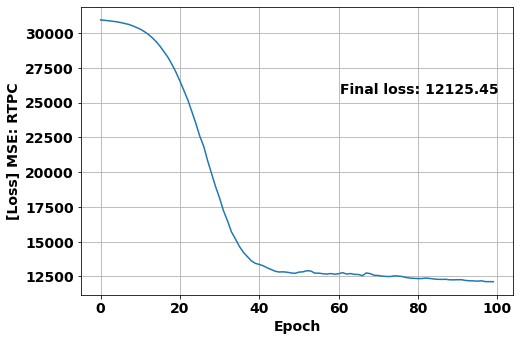

4 0.5922284724274689


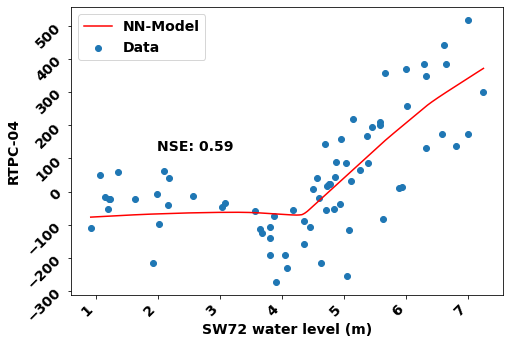

INFO:tensorflow:Assets written to: D:/Research_Notebook/SERVIR/ICIMOD/REOF/hydro2rtpc_mdl_TF/site-SW72_tpc04\assets


In [57]:
train_flag = 1

try:
    os.makedirs(root_output_folder+'/'+out_prefix+'/'+mdl_out_path+'_TF')
except:
    print('Folder: '+root_output_folder+'/'+out_prefix+'/'+mdl_out_path+'_TF already exists')

if train_flag == 1:
    indx_qual_mode = []
    # ----- Train Tensorflow Hydro-to-TPC models mode-by-mode -----
    for ct_mode in range(len(eof_mode_list)):  
        keras.backend.clear_session()    
        mode = eof_mode_list[ct_mode]+1
        print('Building models for mode-'+str(mode).zfill(2))
        site = eof_site_list[ct_mode] 
        tpc = eof_result.temporal_modes.sel(mode=int(mode))        
        hydro_single = hist_hydro_stack[site].dropna(dim='time')

        hydro_site = hydro_single
    
        if eof_high_r_list[ct_mode]<0:
            tpc = tpc*-1    
    
    
        good_hydro = fierpy.match_dates(hydro_site, tpc)
        good_tpc = fierpy.match_dates(tpc, good_hydro)        
    
        X = good_hydro.data.reshape(good_hydro.size,1)
        Y = good_tpc.data.reshape(good_tpc.size,1)    
    
        X_train = X
        Y_train = Y     
    
        # -- adapt function is to get the mean and STD used to normalize the input data of the model --
        normalizer.adapt(X_train)    
    
        # ----- Construct the model and get summary -----
        model = build_and_compile_model(normalizer)
        #if vis_tf_nn==0:
        model.summary()
        #elif vis_tf_nn==1:
        #  plot_model(model, to_file='NOAA_WF\\hydro2rtpc_mdl\\'+data_src+'\\site-'+str(gaugeID_list[site])+'_tpc'+str(mode+1).zfill(2)+'.png', show_shapes=True, show_layer_names=True)
    
         # ----- Fit the model -----
        train_proc = model.fit(
            X_train, 
            Y_train, 
            callbacks=[callback],
            batch_size=32, 
            epochs=100, 
            verbose=0, 
            #validation_split=0.2
        )    
    
        # ----- Plot training progress -----  
        plot_loss(train_proc)

        # ----- Plot model estimation and original scatter plot -----
        X_sim = tf.linspace(np.amin(X), np.amax(X), X.size*10^10)
        Y_sim = model.predict(X_sim)
   

        # ----- The second-time REOF mode screening based on quality of regression models. If qualified, export trained model -----
        Y_mdl = model.predict(X)
        nse = 1 - ( (np.nansum(np.square( Y - Y_mdl ))) / (np.nansum(np.square( Y - np.nanmean(Y) ))) )
        print(mode, nse)
        if nse > 0.5: # Moriasi et al., 2007. Consider NSE>0.5 as satisfactory
        
            indx_qual_mode.append(ct_mode)

            fig = plt.figure()
            ax = fig.add_axes([0,0,1,1])
            plt.scatter(X, Y)
            plt.plot(X_sim, Y_sim, color='r')
            plt.xlabel(str(reaches[site])+' water level (m)', fontdict=fontdict)
            plt.ylabel(tpc_str+'-'+str(mode).zfill(2), fontdict=fontdict)  
            plt.xticks(rotation=45, ha='right')
            plt.yticks(rotation=45)
            plt.legend(['NN-Model','Data'],loc='upper left')
            plt.text(0.2,0.5,'NSE: '+"{:.2f}".format(nse), transform=ax.transAxes)
            plt.savefig(root_output_folder+'/'+out_prefix+'/'+mdl_out_path+'_TF/site-'+str(reaches[site])+'_tpc'+str(mode).zfill(2)+'_sct.png', dpi=300, bbox_inches='tight')
            plt.show()
    
            # ----- Export trained model -----
            model.save(root_output_folder+'/'+out_prefix+'/'+mdl_out_path+'_TF/site-'+str(reaches[site])+'_tpc'+str(mode).zfill(2))  

    eof_mode_list = eof_mode_list[indx_qual_mode]
    eof_site_list = eof_site_list[indx_qual_mode]

# Polynomial regression

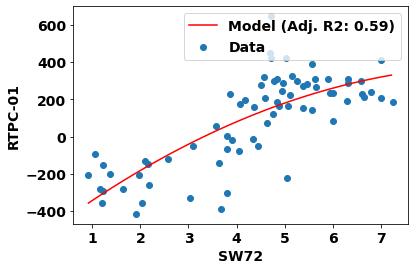

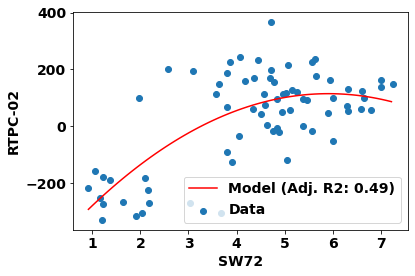

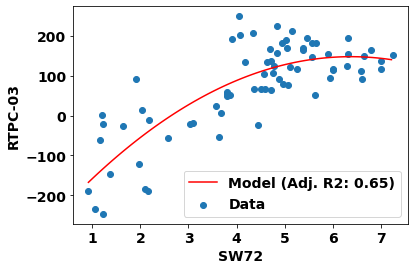

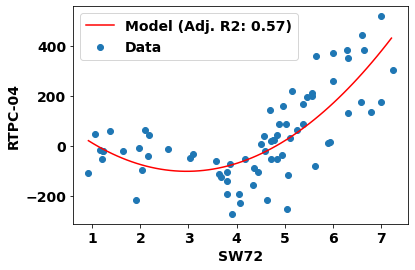

In [647]:
deoutlier = 0

try:
    os.makedirs(root_output_folder+'/'+out_prefix+'/'+mdl_out_path)
except:
    print('Folder: '+root_output_folder+'/'+out_prefix+'/'+mdl_out_path+' already exists')
    
for ct_mode in range(len(eof_mode_list)):
    # get mode of tpc
    mode = eof_mode_list[ct_mode]+1
    site = eof_site_list[ct_mode]

    tpc = eof_result.temporal_modes.sel(mode=int(mode))    

    if eof_high_r_list[ct_mode]<0:
        tpc = tpc*-1    
    
    # -- get hydrological data coincident with satellite image acquisitions --
    hydro_single = hist_hydro_stack[site]
    hydro_single = hydro_single.dropna(dim='time')
        
    if deoutlier==1:
        indx_good_hydro = (np.abs(sci.stats.zscore(hydro_single))<=3)
        hydro_site = hydro_single[indx_good_hydro]
    elif deoutlier==0:
        hydro_site = hydro_single    
        
    good_hydro = fierpy.match_dates(hydro_site, tpc)      
    good_tpc = fierpy.match_dates(tpc, good_hydro)
       
    mdl = np.poly1d( np.polyfit(good_hydro, good_tpc, 2) )
    np.save(root_output_folder+'/'+out_prefix+'/'+mdl_out_path+'/site-'+str(reaches[eof_site_list[ct_mode]])+'_tpc'+str(mode).zfill(2)+'.npy', mdl)
    
    # ----- Get R-Square and Adjusted R-Square -----
    r2 = metrics.r2_score(good_tpc, mdl(good_hydro))
    adj_r2 = 1 - (1-r2)*(len(good_tpc)-1)/(len(good_tpc)-1-1)
    
    y_est_plot = mdl( np.arange( np.nanmin(good_hydro), np.nanmax(good_hydro), 0.1) )    

    plt.scatter(good_hydro, good_tpc)
    plt.plot( np.arange( np.nanmin(good_hydro), np.nanmax(good_hydro), 0.1), y_est_plot, color='r' )
    plt.legend(['Model (Adj. R2: '+"{:.2f}".format(adj_r2)+')','Data'])
    plt.xlabel(str(reaches[site])+'', fontdict=fontdict)
    plt.ylabel('RTPC-'+str(mode).zfill(2), fontdict=fontdict)
    plt.savefig(root_output_folder+'/'+out_prefix+'/'+mdl_out_path+'/site-'+str(reaches[site])+'_tpc'+str(mode).zfill(2)+'_sct.png', dpi=300, bbox_inches='tight')
    plt.show()    



# FIER SAR-like image synthesis

In [49]:
# ----- Synthesize images on the date of interest -----
# -- Define date of interest --
doi = '2021-09-20'

# -- Define the type of regression model to be used --
reg_opt = 0
# 0: Tensorflow regression
# 1: Polynomial regression

Folder: D:/Research_Notebook/SERVIR/ICIMOD/REOF/water_map/ already exists
Folder: D:/Research_Notebook/SERVIR/ICIMOD/REOF/dB_map/ already exists


C:\Users\Ncalm\AppData\Local\Temp/ipykernel_21084/2397319900.py:69: RuntimeWarning:

Mean of empty slice



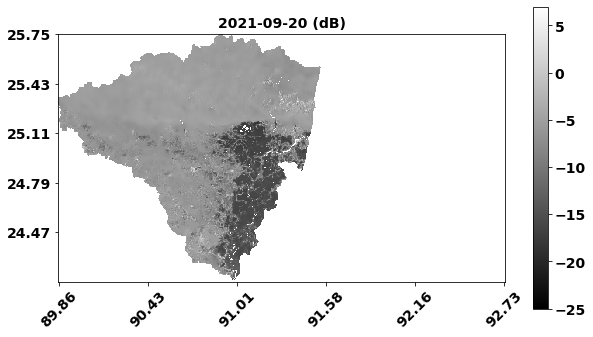

In [59]:
try:
    os.makedirs(root_output_folder+'/'+out_prefix+'/water_map')
except:
    print('Folder: '+root_output_folder+'/'+out_prefix+'/water_map/ already exists')

try:
    os.makedirs(root_output_folder+'/'+out_prefix+'/dB_map')
except:
    print('Folder: '+root_output_folder+'/'+out_prefix+'/dB_map/ already exists')
    
    
# -- If it historical or forecasted --
if pd.to_datetime(doi).strftime('%Y-%m-%d') <  pd.Timestamp.today().strftime('%Y-%m-%d'):
    forecast_opt = 0
else:
    if pd.to_datetime(doi).strftime('%Y-%m-%d') >  pd.Timestamp.today().strftime('%Y-%m-%d'):
        forecast_opt = 1    
    elif pd.to_datetime(doi).strftime('%Y-%m-%d') ==  pd.Timestamp.today().strftime('%Y-%m-%d'):
        forecast_opt = 2  

missing_data_flag = 0
for ct_mode in range(len(eof_mode_list)):
    # get mode of tpc
    mode = eof_mode_list[ct_mode]+1
    site = eof_site_list[ct_mode]            
    
    sm = eof_result.spatial_modes.sel(mode=int(mode))
    
    if forecast_opt==0:
        hydro_single = hist_hydro_stack[site]
    else:
        if forecast_opt==1:
            hydro_single = fct_hydro[site]
        elif forecast_opt==2:
            hydro_single = fct_hydro_record[site]
        
    hydro_single = hydro_single.dropna(dim='time')
    indx_date = np.argwhere(hydro_single.time.values==doi)   
    
    if len(indx_date)==0:
        print('Required hydrological data is missing on the date-of-interest. Try other dates')
        missing_data_flag = 1
        break
    
    if eof_high_r_list[ct_mode]<0:
        #tpc = tpc*-1    
        sm = sm*-1
    
    #print(hydro_single.values[indx_date])
    if reg_opt == 0:
        in_model = models.load_model(root_output_folder+'/'+out_prefix+'/'+mdl_out_path+'_TF/site-'+str(reaches[site])+'_tpc'+str(mode).zfill(2))     
        est_tpc = in_model.predict(hydro_single.values[indx_date])        
        outfig_prefix = 'TF_'
    elif reg_opt == 1:
        in_model = np.poly1d(np.load(root_output_folder+'/'+out_prefix+'/'+mdl_out_path+'/site-'+str(reaches[site])+'_tpc'+str(mode).zfill(2)+'.npy'))
        est_tpc = in_model(hydro_single.values[indx_date])
        outfig_prefix = 'poly_'
        
    if ct_mode==0:
        syn_sar = sm*est_tpc
    else:
        syn_sar = syn_sar + sm*est_tpc
        
if missing_data_flag != 1:
    # -- Remove empty coordinate and rename the data array to avoid confusion --    
    #print(syn_sar)
    #syn_sar = syn_sar.drop_vars('mode')
    # -- Real all-time mean, dry-time mean/STD --
    all_meanVV = np.nanmean(img_stackVV.VV.values, axis=0)
    syn_sar = syn_sar + all_meanVV
    syn_sar.name = 'intensity'  
   
    plt.figure(figsize=(plt_width,plt_width*(img_stackVV.sizes['lat']/img_stackVV.sizes['lon'])))
    plt.imshow(syn_sar, cmap='gray', vmin=-25, vmax=7,interpolation='none')
    plt.xticks(lon_indx_list, lon_list, rotation=45)
    plt.yticks(lat_indx_list, lat_list)
    plt.title(doi+' (dB)', fontdict=fontdict)
    plt.colorbar()
    plt.savefig(root_output_folder+'/'+out_prefix+'/dB_map/'+outfig_prefix+doi+'.png', dpi=300, bbox_inches='tight')
    plt.show()

else:
    del syn_sar
    print('Required hydrological data is missing on the date-of-interest. Try other dates')


# Z-Score water classification

**Case of FIER-synthesized SAR-like image**

In [60]:
# ----- Calculate statistics image as references for water classification -----
# -- Real dry-time mean and STD --
dry_mon = np.array([12,1])
mon_array = pd.DatetimeIndex([pd.to_datetime(date_str).strftime('%Y-%m-%d') for date_str in img_stackVV.time.values]).month

dry_mon_indx = np.isin(mon_array, dry_mon)
dry_meanVV = np.nanmean( img_stackVV.VV[dry_mon_indx, :, :], axis=0 )
dry_stdVV = np.nanstd( img_stackVV.VV[dry_mon_indx, :, :], axis=0 )

C:\Users\Ncalm\AppData\Local\Temp/ipykernel_21084/584262522.py:7: RuntimeWarning:

Mean of empty slice

D:\anaconda3\envs\fierpy\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning:

Degrees of freedom <= 0 for slice.



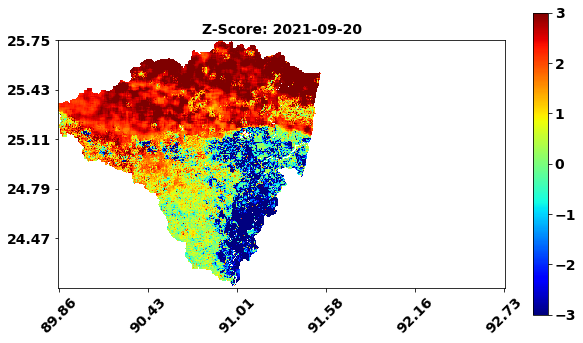

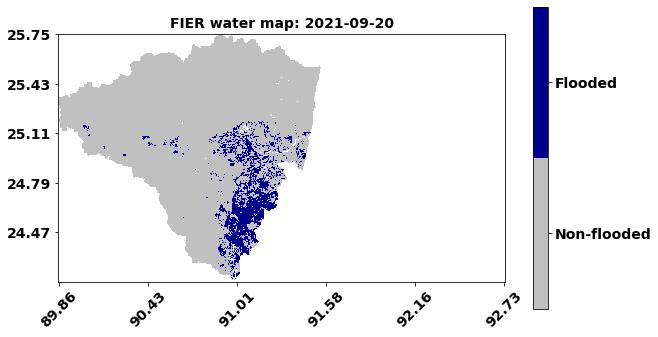

In [61]:
# ----- Z-Score water classification -----
zscore_threshold = -3
z_score_img = (syn_sar-dry_meanVV)/dry_stdVV


# -- Plot Z-Score image --
plt.figure(figsize=(plt_width,plt_width*(img_stackVV.sizes['lat']/img_stackVV.sizes['lon'])))
plt.imshow(z_score_img, cmap='jet', vmin=-3, vmax=3, interpolation='None')
plt.colorbar()
plt.xticks(lon_indx_list, lon_list, rotation=45)
plt.yticks(lat_indx_list, lat_list)
plt.title('Z-Score: '+doi, fontdict=fontdict)
plt.show()

# -- Generate water map --
aoi_indx = np.argwhere( ~np.isnan(img_stackVV.VV.values[0]) )
water_indx = np.argwhere( z_score_img.values < zscore_threshold )
water_map = np.empty((syn_sar.shape[0], syn_sar.shape[1]))
water_map[:] = nan
water_map[aoi_indx[:,0], aoi_indx[:,1]] = 0
water_map[water_indx[:,0], water_indx[:,1]] = 1

water_cmap =  matplotlib.colors.ListedColormap(["silver","darkblue"])
plt.figure(figsize=(plt_width,plt_width*(img_stackVV.sizes['lat']/img_stackVV.sizes['lon'])))
plt.imshow(water_map, cmap=water_cmap, interpolation='None')
plt.title('FIER water map: '+doi, fontdict=fontdict)
plt.xticks(lon_indx_list, lon_list, rotation=45)
plt.yticks(lat_indx_list, lat_list)
plt.clim(vmin=-0.5, vmax=1.5)
cbar = plt.colorbar(ticks=[0,1])
c_ticklabels = ['Non-flooded','Flooded']
cbar.set_ticklabels(c_ticklabels)
plt.savefig(root_output_folder+'/'+out_prefix+'/water_map/'+outfig_prefix+doi+'.png', dpi=300, bbox_inches='tight')
plt.show()

**Case of Real SAR image**

1. Get VH-polarization image stack. This is to calculate the reference statistics images (mean, STD) for VH-polarization

In [62]:
if os.path.exists(root_output_folder+"/input/"+img_stack_name+"_VH.nc"):
    img_stackVH = xr.open_dataset(root_output_folder+"/input/"+img_stack_name+"_VH.nc")
else:
    
    # ----- Create a session -----
    # -- Provide Google Cloud ProjectID and the path to the credential --
    PROJECT_ID= 'fier-314819'
    CREDENTIAL='D:/Research_Notebook/credential/fier-314819-267d62ad4e0b.json'
    session=restee.EESession(PROJECT_ID, CREDENTIAL)

    # ----- Define the domain -----
    # -- Define spatial resolution (unit: degree) -- 
    res = 0.005 
    res_str = str(int(100000*res)).zfill(3)
    domain = restee.Domain.from_ee_geometry(session, aoi, resolution=res)    
    
    # -- GEE ImageCollection to XARRAY dataset --
    init_img_stackVH = restee.imgcollection_to_xarray(session, domain, S1_ImgCol_procVH ,bands=['VH']) 
    
    # -- sort data by time in ascending order --
    init_img_stackVH = init_img_stackVH.sortby("time")
    init_img_stackVH["time"] = init_img_stackVH["time"].dt.strftime("%Y-%m-%d")

    # ----- Make pixels out of image frame as NaN -----
    init_img_stackVH = init_img_stackVH.where(init_img_stackVH['VH']!=0)

    # ----- Only keep the pixels that consistently have data over time. Others are set as NaN -----
    img_stack_meanVH = init_img_stackVH.mean(dim='time', skipna=False, keep_attrs=True)
    indx_img_stack_nullVH = img_stack_meanVH.isnull(keep_attrs=True)
    img_stackVH = init_img_stackVH.where(~indx_img_stack_nullVH['VH'])

    # ----- Get permanent water from the JRC Global Surface Water Data from GEE (GEE Image) -----
    # ----- to mask out permanent water from the SAR dataset             
    jrc_org = (
        ee.Image("JRC/GSW1_3/GlobalSurfaceWater")
    )

    jrc_in = restee.img_to_xarray(session, domain, jrc_org, bands=['transition']) 
    jrc_aoi = jrc_in.where(~indx_img_stack_nullVH['VH'])
    pwater_mask = jrc_aoi.transition.values==1

    # ----- Mask out permanent water body -----
    img_stackVH = img_stackVH.where(~pwater_mask)

    # ----- Export dataset as NetCDF -----
    try:
        os.makedirs(root_output_folder+"/input")
    except:
        print('Folder: '+root_output_folder+'/input already exist')
    img_stackVH.to_netcdf(root_output_folder+"/input/"+img_stack_name+"_VH.nc")
    
# ----- Calculate statistics image as references for water classification -----
# -- Real all-time mean, dry-time mean/STD --
all_meanVH = np.nanmean(img_stackVH.VH.values, axis=0)
dry_meanVH = np.nanmean( img_stackVH.VH[dry_mon_indx, :, :], axis=0 )
dry_stdVH = np.nanstd( img_stackVH.VH[dry_mon_indx, :, :], axis=0 )    

C:\Users\Ncalm\AppData\Local\Temp/ipykernel_21084/837089284.py:54: RuntimeWarning:

Mean of empty slice

C:\Users\Ncalm\AppData\Local\Temp/ipykernel_21084/837089284.py:55: RuntimeWarning:

Mean of empty slice



2. Retrieve real SAR image on the DOI if available

In [63]:
end_doi = ee.Date(doi).advance(1,'day').format('Y-M-d').getInfo()

# ----- Cross-compare with external flood map -----
# -- Use real SAR flood map --
# ----- Sentinel-1 SAR ImageCollection -----
S1_ImgCol_cmp = (
    ee.ImageCollection('COPERNICUS/S1_GRD')
    .filterBounds(aoi)
    .filter(ee.Filter.date(doi,end_doi))
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
    .filter(ee.Filter.eq('relativeOrbitNumber_start',Rel_Orb))
    .filter(ee.Filter.eq('relativeOrbitNumber_stop',Rel_Orb))
    .filter(ee.Filter.eq('instrumentMode', 'IW'))
    .filter(ee.Filter.eq('platform_number', 'A'))
    .filter(ee.Filter.eq('orbitProperties_pass',Orb_Prop))
)

hf_S1_ImgCol_cmp = hf.datasets.Dataset.from_imgcollection(S1_ImgCol_cmp)
if mosaic_opt==1:
    hf_S1_ImgCol_cmp = hf_S1_ImgCol_cmp.aggregate_time(clip_to_area=True)
S1_ImgCol_flt_msc_cmp = hf_S1_ImgCol_cmp.apply_func(hf.slope_correction, elevation=ee.Image("NASA/NASADEM_HGT/001").select("elevation"))
S1_ImgCol_flt_msc_filt_cmp = S1_ImgCol_flt_msc_cmp.apply_func(hf.filtering.gamma_map)
S1_ImgCol_proc_cmpVV = ee.ImageCollection(S1_ImgCol_flt_msc_filt_cmp.collection.select('VV').map(img_col_clip))
S1_ImgCol_proc_cmpVH = ee.ImageCollection(S1_ImgCol_flt_msc_filt_cmp.collection.select('VH').map(img_col_clip))

In [64]:
# ----- Create a session -----
# -- Provide Google Cloud ProjectID and the path to the credential --
PROJECT_ID= 'fier-314819'
CREDENTIAL='D:/Research_Notebook/credential/fier-314819-267d62ad4e0b.json'
session=restee.EESession(PROJECT_ID, CREDENTIAL)

# ----- Define the domain -----
domain = restee.Domain.from_ee_geometry(session, aoi, resolution=res)  


# -- RESTEE converts GEE ImageCollection as XARRAY dataset --
init_img_stack_cmpVV = restee.imgcollection_to_xarray(session, domain, S1_ImgCol_proc_cmpVV ,bands=['VV']) 


init_img_stack_cmpVV = init_img_stack_cmpVV.sortby("time")
init_img_stack_cmpVV["time"] = init_img_stack_cmpVV["time"].dt.strftime("%Y-%m-%d")

# ----- Make pixels out of image frame as NaN -----
init_img_stack_cmpVV = init_img_stack_cmpVV.where(init_img_stack_cmpVV['VV']!=0)

# -- Make sure each pixel location consistently has data over time, otherwise set it as NaN --
img_stack_mean_cmpVV = img_stackVV.mean(dim='time', skipna=False, keep_attrs=True)
indx_img_stack_null_cmpVV = img_stack_mean_cmpVV.isnull(keep_attrs=True)
img_stack_cmpVV = init_img_stack_cmpVV.where(~indx_img_stack_null_cmpVV['VV'])


In [65]:
# -- RESTEE converts GEE ImageCollection as XARRAY dataset --
init_img_stack_cmpVH = restee.imgcollection_to_xarray(session, domain, S1_ImgCol_proc_cmpVH ,bands=['VH']) 

init_img_stack_cmpVH = init_img_stack_cmpVH.sortby("time")
init_img_stack_cmpVH["time"] = init_img_stack_cmpVH["time"].dt.strftime("%Y-%m-%d")

# ----- Make pixels out of image frame as NaN -----
init_img_stack_cmpVH = init_img_stack_cmpVH.where(init_img_stack_cmpVH['VH']!=0)

# -- Make sure each pixel location consistently has data over time, otherwise set it as NaN --
img_stack_mean_cmpVH = img_stackVH.mean(dim='time', skipna=False, keep_attrs=True)
indx_img_stack_null_cmpVH = img_stack_mean_cmpVH.isnull(keep_attrs=True)
img_stack_cmpVH = init_img_stack_cmpVH.where(~indx_img_stack_null_cmpVH['VH'])

In [66]:
"""
# -- Mask out permanent water body --
img_stack_cmpVV = img_stack_cmpVV.where(~pwater_mask).VV.values[0].squeeze()
img_stack_cmpVH = img_stack_cmpVH.where(~pwater_mask).VH.values[0].squeeze()
"""
img_stack_cmpVV = img_stack_cmpVV.VV.values[0].squeeze()
img_stack_cmpVH = img_stack_cmpVH.VH.values[0].squeeze()


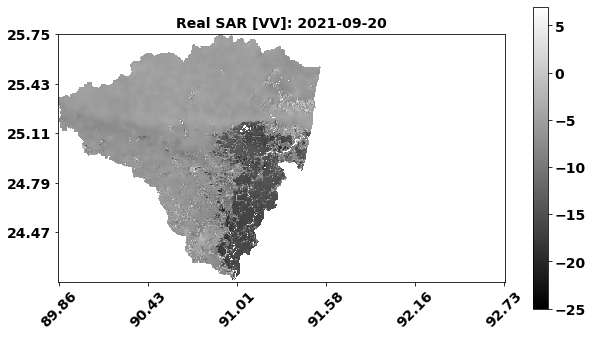

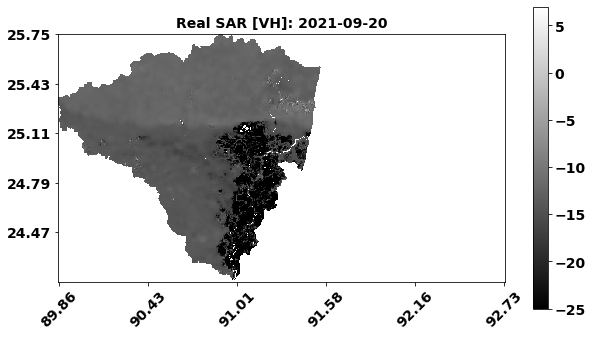

In [67]:
plt.figure(figsize=(plt_width,plt_width*(img_stackVV.sizes['lat']/img_stackVV.sizes['lon'])))
plt.imshow(img_stack_cmpVV, cmap='gray', vmin=-25, vmax=7, interpolation='None')
plt.title('Real SAR [VV]: '+doi, fontdict=fontdict)
plt.colorbar()
plt.xticks(lon_indx_list, lon_list, rotation=45)
plt.yticks(lat_indx_list, lat_list)
plt.savefig(root_output_folder+'/'+out_prefix+'/dB_map/real_'+doi+'VV.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(plt_width,plt_width*(img_stackVV.sizes['lat']/img_stackVV.sizes['lon'])))
plt.imshow(img_stack_cmpVH, cmap='gray', vmin=-25, vmax=7, interpolation='None')
plt.title('Real SAR [VH]: '+doi, fontdict=fontdict)
plt.colorbar()
plt.xticks(lon_indx_list, lon_list, rotation=45)
plt.yticks(lat_indx_list, lat_list)
plt.savefig(root_output_folder+'/'+out_prefix+'/dB_map/real_'+doi+'VH.png', dpi=300, bbox_inches='tight')
plt.show()

3. Water classification and visualize

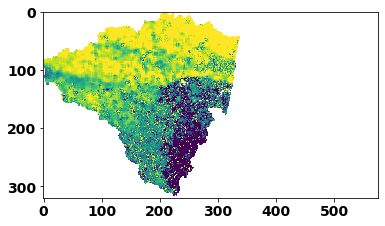

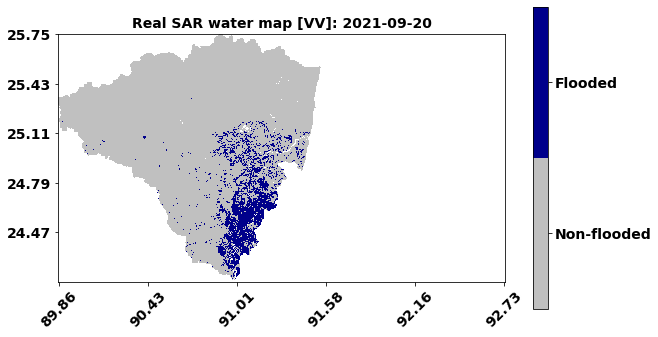

In [68]:
z_score_img_cmpVV = (img_stack_cmpVV-dry_meanVV)/dry_stdVV
z_score_img_cmpVH = (img_stack_cmpVH-dry_meanVH)/dry_stdVH


plt.imshow(z_score_img_cmpVV, interpolation='None')
plt.clim(vmin=-3, vmax=3)
plt.show()


# -- Generate water map --
#water_indx_cmp = np.concatenate( (np.argwhere( z_score_img_cmpVV < zscore_threshold ), np.argwhere( z_score_img_cmpVH < zscore_threshold)) )
water_indx_cmp = np.argwhere( z_score_img_cmpVV < zscore_threshold )
water_map_cmp = np.empty((syn_sar.shape[0], syn_sar.shape[1]))
water_map_cmp[:] = np.NaN
water_map_cmp[aoi_indx[:,0], aoi_indx[:,1]]=0
water_map_cmp[water_indx_cmp[:,0], water_indx_cmp[:,1]] = 1


plt.figure(figsize=(plt_width,plt_width*(img_stackVV.sizes['lat']/img_stackVV.sizes['lon'])))
plt.imshow(water_map_cmp, cmap=water_cmap, interpolation='None')
plt.clim(vmin=-0.5, vmax=1.5)
cbar = plt.colorbar(ticks=[0,1])
c_ticklabels = ['Non-flooded','Flooded']
cbar.set_ticklabels(c_ticklabels)
plt.title('Real SAR water map [VV]: '+doi, fontdict=fontdict)
plt.xticks(lon_indx_list, lon_list, rotation=45)
plt.yticks(lat_indx_list, lat_list)
plt.savefig(root_output_folder+'/'+out_prefix+'/water_map/real_'+doi+'VV.png', dpi=300, bbox_inches='tight')
plt.show()

# Cross-comparison: FIER v.s. Real 

**Based on the confusion matrix which consists of True Positive (TP), False Positive (FP), False Negative (FN), and True Negative (TN)**


Folder: D:/Research_Notebook/SERVIR/ICIMOD/REOF/cross_cmp/ already exists


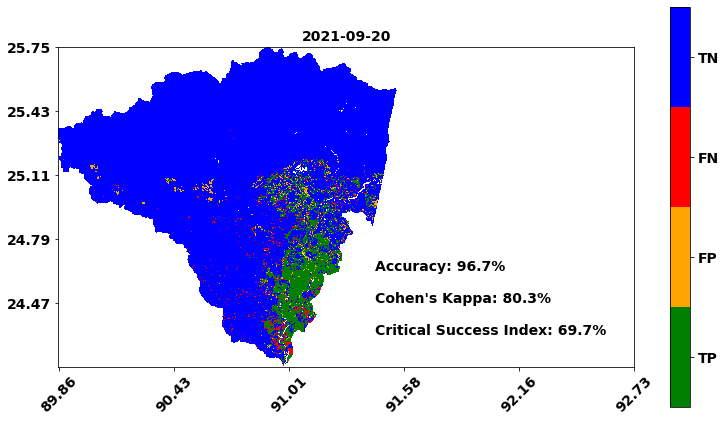

In [75]:
try:
    os.makedirs(root_output_folder+'/'+out_prefix+'/cross_cmp')
except:
    print('Folder: '+root_output_folder+'/'+out_prefix+'/cross_cmp/ already exists')

# ----- Get difference bewteen flood maps -----
dif_map = water_map - water_map_cmp

total_pix = len( np.argwhere( ~np.isnan(img_stackVV.VV.values[0]) ) )
tpn_pix = len( np.argwhere(dif_map==0) )
with np.errstate(divide='ignore',invalid='ignore'):
    tp_indx = np.argwhere( (dif_map / water_map)==0 )
    tp_pix = len( tp_indx )
tn_pix = tpn_pix - tp_pix
fp_pix = len( np.argwhere(dif_map==1) )
fn_pix = len( np.argwhere(dif_map==-1) )

cmp_map = np.empty((syn_sar.shape[0], syn_sar.shape[1]))
cmp_map[:]=nan
cmp_map[aoi_indx[:,0], aoi_indx[:,1]] = 4
cmp_map[ tp_indx[:,0], tp_indx[:,1] ] = 1
cmp_map[ np.argwhere(dif_map==1)[:,0], np.argwhere(dif_map==1)[:,1] ] = 2
cmp_map[ np.argwhere(dif_map==-1)[:,0], np.argwhere(dif_map==-1)[:,1] ] = 3


acc = tpn_pix*100/total_pix
ckp = 2*(tp_pix*tn_pix - fn_pix*fp_pix)*100 / ( (tp_pix+fp_pix)*(fp_pix+tn_pix)+(tp_pix+fn_pix)*(fn_pix+tn_pix) )
csi = (tp_pix)*100 / (tp_pix + fp_pix + fn_pix)

cmp_clrmap =  matplotlib.colors.ListedColormap(["green","orange","red","blue"])
fig = plt.figure(figsize=(plt_width,plt_width*(img_stackVV.sizes['lat']/img_stackVV.sizes['lon'])))
ax = fig.add_axes([0, 0, 1, 1])
plt.imshow(cmp_map, cmap=cmp_clrmap, interpolation='None')
plt.clim(vmin=0.5,vmax=4.5)
cbar = plt.colorbar(ticks=[1,2,3,4])
c_ticklabels = ['TP', 'FP', 'FN', 'TN']
cbar.set_ticklabels(c_ticklabels)
plt.xticks(lon_indx_list, lon_list, rotation=45)
plt.yticks(lat_indx_list, lat_list)
plt.text(0.55,0.3,'Accuracy: '+"{:.1f}".format( acc )+'%', transform=ax.transAxes)
plt.text(0.55,0.2,"Cohen's Kappa: "+"{:.1f}".format( ckp )+'%', transform=ax.transAxes)
plt.text(0.55,0.1,"Critical Success Index: "+"{:.1f}".format( csi )+'%', transform=ax.transAxes)
plt.title(doi,fontdict=fontdict)
plt.savefig(root_output_folder+'/'+out_prefix+'/cross_cmp/cmp_'+outfig_prefix+doi+'.png', dpi=300, bbox_inches='tight')
plt.show()


In [85]:
root_output_folder

'D:/Research_Notebook/SERVIR/ICIMOD'

# Neccessary data export

In [108]:
xr_RSM = xr.Dataset(
    data_vars = dict(
        spatial_modes = (["lat","lon","mode"], eof_result.spatial_modes.sel(mode=eof_mode_list+1)),
        hydro_site = (["mode"], np.asarray(reaches)[eof_site_list])   
    ),
    
    coords=dict(
        lat=(["lat"], eof_result.lat),
        lon=(["lon"], eof_result.lon),
        mode=(["mode"], eof_result.spatial_modes.sel(mode=eof_mode_list+1).mode)
        
    )

)

In [80]:
xr_all_meanVV = xr.DataArray(
    data = all_meanVV,
    dims=["lat","lon"],
    coords=dict(        
        lat=(["lat"], img_stackVV.lat ),
        lon=(["lon"], img_stackVV.lon)                
    )    
)

xr_dry_meanVV = xr.DataArray(
    data = dry_meanVV,
    dims=["lat","lon"],
    coords=dict(        
        lat=(["lat"], img_stackVV.lat ),
        lon=(["lon"], img_stackVV.lon)                
    )    
)

xr_dry_stdVV = xr.DataArray(
    data = dry_stdVV,
    dims=["lat","lon"],
    coords=dict(        
        lat=(["lat"], img_stackVV.lat ),
        lon=(["lon"], img_stackVV.lon)                
    )    
)

In [120]:
xr_RSM

<xarray.Dataset>
Dimensions:        (lat: 320, lon: 576, mode: 4)
Coordinates:
  * lat            (lat) float64 25.75 25.75 25.74 25.74 ... 24.17 24.16 24.16
  * lon            (lon) float64 89.86 89.86 89.87 89.87 ... 92.72 92.73 92.73
  * mode           (mode) int64 1 2 3 4
Data variables:
    spatial_modes  (lat, lon, mode) float64 nan nan nan nan ... nan nan nan nan
    hydro_site     (mode) <U4 'SW72' 'SW72' 'SW72' 'SW72'

In [112]:
if not os.path.exists(root_output_folder+'/input/stats/'):
    os.makedirs(root_output_folder+'/input/stats/')

if not os.path.exists(root_output_folder+'/'+out_prefix+'/'+sm_str):
    os.makedirs(root_output_folder+'/'+out_prefix+'/'+sm_str+'/')

xr_RSM.to_netcdf(root_output_folder+'/'+out_prefix+'/'+sm_str+'/RSM_hydro.nc')
xr_all_meanVV.to_netcdf(root_output_folder+'/input/stats/all_meanVV.nc')
xr_dry_meanVV.to_netcdf(root_output_folder+'/input/stats/dry_meanVV.nc')
xr_dry_stdVV.to_netcdf(root_output_folder+'/input/stats/dry_stdVV.nc')

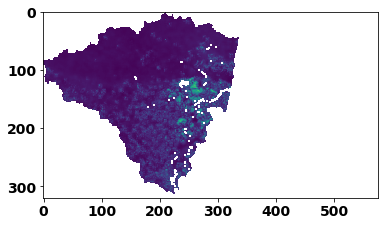

In [119]:
test_xr = xr.open_dataarray(root_output_folder+'/input/stats/dry_stdVV.nc')
plt.imshow(test_xr)
plt.show()